# Ultimate Technologies Inc. Data Analysis

**Imports**

In [196]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sys
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import string
import collections
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.linear_model import Lasso

**Timestamps of user logins based on geolocation**

In [197]:
# Read file
logins_ = pd.read_json(r"C:\Users\yuvem\Downloads\ultimate_challenge_3\ultimate_challenge\logins.json")

In [198]:
# Check shape
logins_.shape

(93142, 1)

**Predictive modeling data**

In [199]:
# Open a connection to json file
ultimate_challenge_file = open(r'C:\Users\yuvem\Downloads\ultimate_challenge_3\ultimate_challenge\ultimate_data_challenge.json', mode='r')
# Read 
ultimate_challenge_json = ultimate_challenge_file.read()

# Close connection
ultimate_challenge_file.close()
# Decode json file
ultimate_challenge_ds = json.loads(ultimate_challenge_json)

# Convert to df
predictive_model_df = pd.DataFrame(ultimate_challenge_ds)

### 1 EDA

In [200]:
logins_.describe()

,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


So, time format is yyyy-mm-dd h:m:s, with first date recorded as 1970-01-01 20:12:16 and last date recorded as 1970-04-13 18:57:38. There is only one column, which is login_time. 

**Goal:**

Our goal with this data is to aggregate the login counts based on 15minute time intervals, visualize, and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. We have to *illustrate* important features of the demand (like daily cycles) and *report* data quality issues.

In [201]:
# Create a column filled with 1's
logins_['fifteen_counts'] = 1

# First, set index as login_time
logins_.set_index('login_time', inplace=True)

# Resample by 15 min intervals
logins_15T = logins_.resample('15T').sum()

# Check
logins_15T.head(5)

,fifteen_counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [202]:
logins_15T.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   fifteen_counts  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


### 2 Data Wrangling

Okay, so there is a total of 9788 entries, which is going to be a lot of points if plotted. It's probably best to break this down to a hourly, daily, weekly, and monthly. It would be nice to see hourly data and daily data as a seaborn barplot. The weekly, and monthly we will do a time series plot.

**Hourly**

In [203]:
# We resampled earlier by 15 min, now we resample to hourly. Then, we will view the first 24 hours/1 day
login_perHour = logins_.resample('H').sum().reset_index()
login_perHour.rename({'fifteen_counts':'hourly_counts'}, axis=1, inplace=True)
login_perHour.head(24)

,login_time,hourly_counts
0,1970-01-01 20:00:00,24
1,1970-01-01 21:00:00,9
2,1970-01-01 22:00:00,21
3,1970-01-01 23:00:00,58
4,1970-01-02 00:00:00,53
5,1970-01-02 01:00:00,33
6,1970-01-02 02:00:00,43
7,1970-01-02 03:00:00,28
8,1970-01-02 04:00:00,9
9,1970-01-02 05:00:00,11


In [204]:
# Separate dataset with index reset
logins_15T_reset = logins_15T.reset_index()
logins_15T_reset

,login_time,fifteen_counts
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


In [205]:
# Let's use the dataset with 15min interval. By weekdays, 0=Monday, 6=Sunday
# Create new column 'hour' then sort by 'fifteen_counts'
logins_15T_reset['hour'] = logins_15T_reset['login_time'].dt.hour
# Create a new column 'day' by each day (0-6)
logins_15T_reset['day'] = logins_15T_reset['login_time'].dt.dayofweek
login_hourly = logins_15T_reset.sort_values(by='fifteen_counts', ascending = False)

# Create new dataframe with count and hour
login_hourly_counts = login_hourly[['fifteen_counts', 'hour']]
login_hourly_counts = login_hourly.groupby('hour').sum().reset_index()
login_hourly_counts

,hour,fifteen_counts,day
0,0,5993,1236
1,1,6317,1236
2,2,5800,1236
3,3,4831,1236
4,4,5034,1236
5,5,2945,1236
6,6,1138,1236
7,7,815,1236
8,8,818,1236
9,9,1527,1236


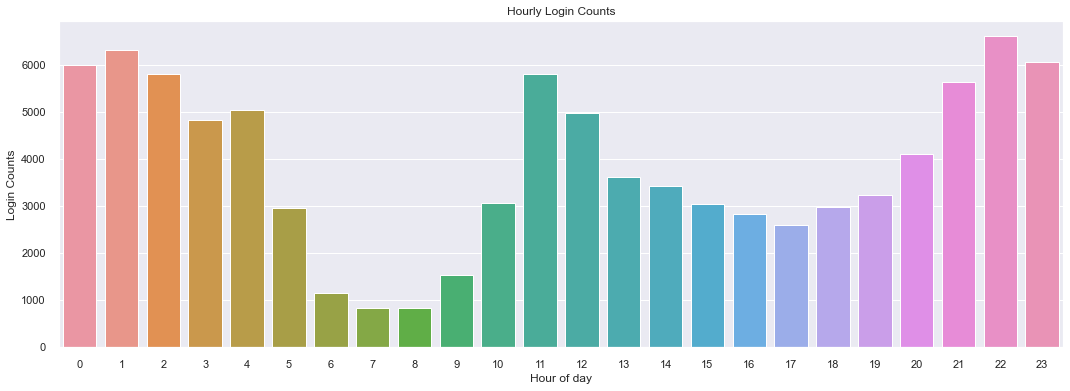

In [206]:
# barplot total logins per hour
plt.figure(figsize=(18,6))
sns.barplot(x= 'hour', y='fifteen_counts', data = login_hourly_counts)
plt.xlabel('Hour of day')
plt.title('Hourly Login Counts')
plt.ylabel('Login Counts')
plt.show()

22:00 is the busiest time and starts quieting down by 2AM, and by 7AM and 8AM it is really slow. Now we have an aggregate per hour of day. What about for each day of the week by hour?

In [207]:
login_perHour.columns

Index(['login_time', 'hourly_counts'], dtype='object')

In [208]:
# We'll use the data resampled to hourly. 
# Create new column 'hour'
login_perHour['hour'] = login_perHour['login_time'].dt.hour
# Create column for day
login_perHour['day'] = login_perHour['login_time'].dt.dayofweek

# Group by day and hour for plot
grouped_login_hourly_byDay = login_perHour.groupby(['day','hour']).sum().reset_index()

In [209]:
grouped_login_hourly_byDay

,day,hour,hourly_counts
0,0,0,531
1,0,1,414
2,0,2,312
3,0,3,236
4,0,4,206
...,...,...,...
163,6,19,632
164,6,20,612
165,6,21,625
166,6,22,583


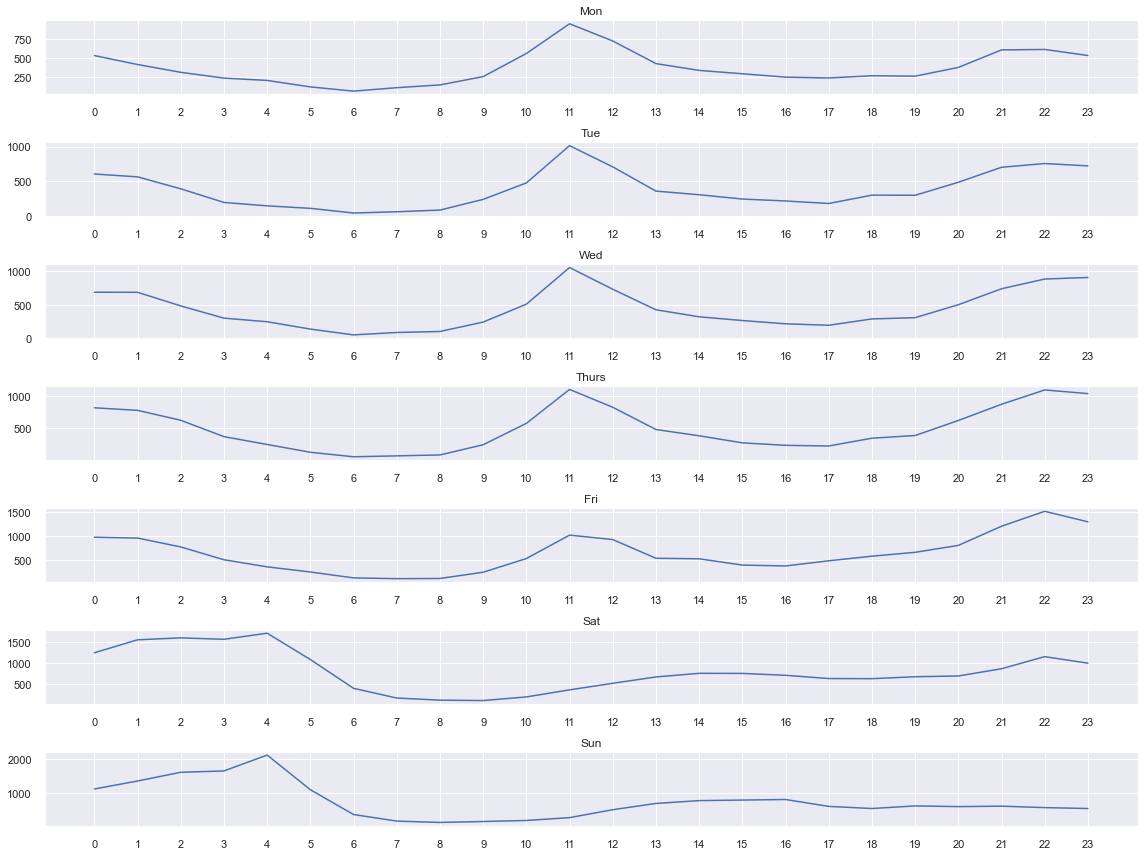

In [210]:
DAY = ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

# Figure for plot
fig, ax = plt.subplots(nrows=7, figsize=(16, 12))

# For loop for day
# Set 'hour' as index
for i in range(7):
    ax[i].plot(grouped_login_hourly_byDay.loc[grouped_login_hourly_byDay['day']==i, ['hour', 'hourly_counts']].set_index('hour'))
    ax[i].set_title(DAY[i])
    ax[i].set_xticks(np.arange(24))
    
plt.tight_layout()

**Sunday and Saturday are congruous, with peak time being 4AM. Seems like on Fridays 11PM is when the party starts, and on Thursday there are two parties, one at 11AM and the other at 11PM. Afternoons are busiest for weekdays, Monday through Thursday, then dies down from Friday through Sunday. In all days, mornings from 6AM to 8AM are a snooze.** 

**Daily**

In [211]:
# We've got a good idea of the days by hour, but what about an aggregate by day?
# Create a new column 'day' by each day (0-6)
logins_15T_reset['day'] = logins_15T_reset['login_time'].dt.dayofweek
login_daily = logins_15T_reset.sort_values(by='fifteen_counts', ascending=False)

# Create new dataframe with count and hour
login_daily_counts = login_daily[['fifteen_counts', 'day']]
login_daily_counts = login_daily_counts.groupby('day').sum().reset_index()

# Ordered categorical list
login_daily_counts['day'] = ['Mon', 'Tues', 'Wed','Thurs','Fri', 'Sat', 'Sun']
login_daily_counts = login_daily_counts[['day', 'fifteen_counts']]
login_daily_counts

,day,fifteen_counts
0,Mon,8823
1,Tues,9268
2,Wed,10339
3,Thurs,11960
4,Fri,15208
5,Sat,19377
6,Sun,18167


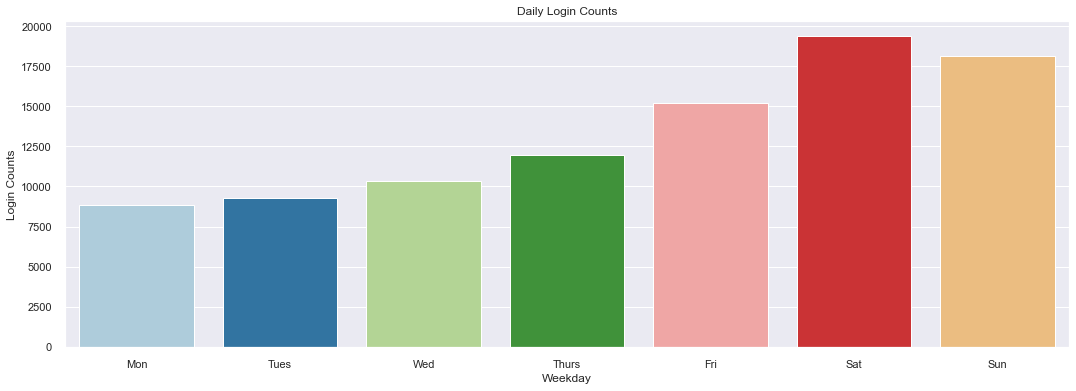

In [212]:
# barplot total logins per day
plt.figure(figsize=(18,6))
sns.set_palette("Paired")
sns.barplot(x= 'day', y='fifteen_counts', data = login_daily_counts)
plt.xlabel('Weekday')
plt.title('Daily Login Counts')
plt.ylabel('Login Counts')
plt.show()

**Most logins recorded on weekends, Saturday and Sunday. Monday has the least logins, and logins increase gradually from Monday to Saturday, then goes down a little bit by Sunday.**

**Monthly**

In [213]:
# Resample data to daily
login_perDay = logins_.resample('1D').sum()
login_perDay.rename({'fifteen_counts':'daily_counts'}, axis=1, inplace=True)

In [216]:
login_perDay_reset = login_perDay.reset_index()

In [217]:
# Create column for month
login_perDay_reset['month'] = login_perDay_reset['login_time'].dt.month
login_perDay_reset

,login_time,daily_counts,month
0,1970-01-01,112,1
1,1970-01-02,681,1
2,1970-01-03,793,1
3,1970-01-04,788,1
4,1970-01-05,459,1
...,...,...,...
98,1970-04-09,818,4
99,1970-04-10,1009,4
100,1970-04-11,1352,4
101,1970-04-12,1409,4


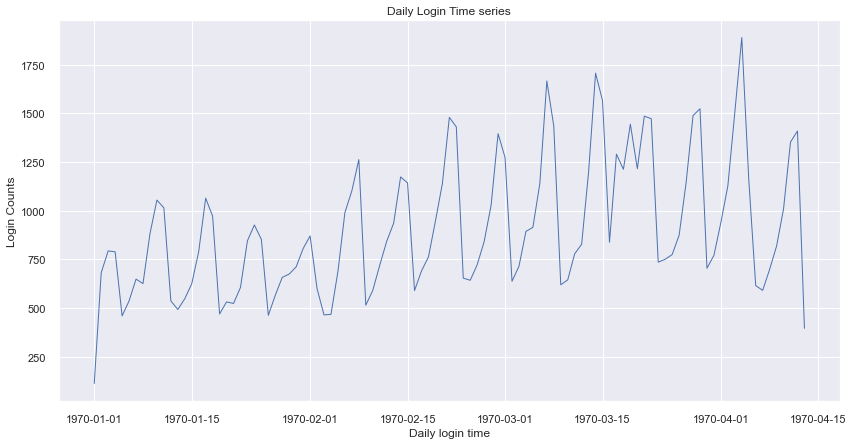

In [218]:
# Plot daily data
plt.style.use('seaborn')
plt.figure(figsize=(14,7))
sns.set(font_scale = 1)
sns.lineplot(data=login_perDay_reset, x='login_time', y='daily_counts', linewidth= 1.0)
plt.xlabel('Daily login time')
plt.ylabel('Login Counts')
plt.title('Daily Login Time series')
plt.show()

So data runs only from January to April, with approximately 15-16 peaks. Let's zoom in and see which months have the most peaks.

In [219]:
# Plot didn't work out with the code below, so I'll try making a dataframe per month
jan = login_perDay[login_perDay.index.month == 1]
feb = login_perDay[login_perDay.index.month == 2]
mar = login_perDay[login_perDay.index.month == 3]
apr = login_perDay[login_perDay.index.month == 4]

# full list of months
months = [jan, feb, mar, apr]

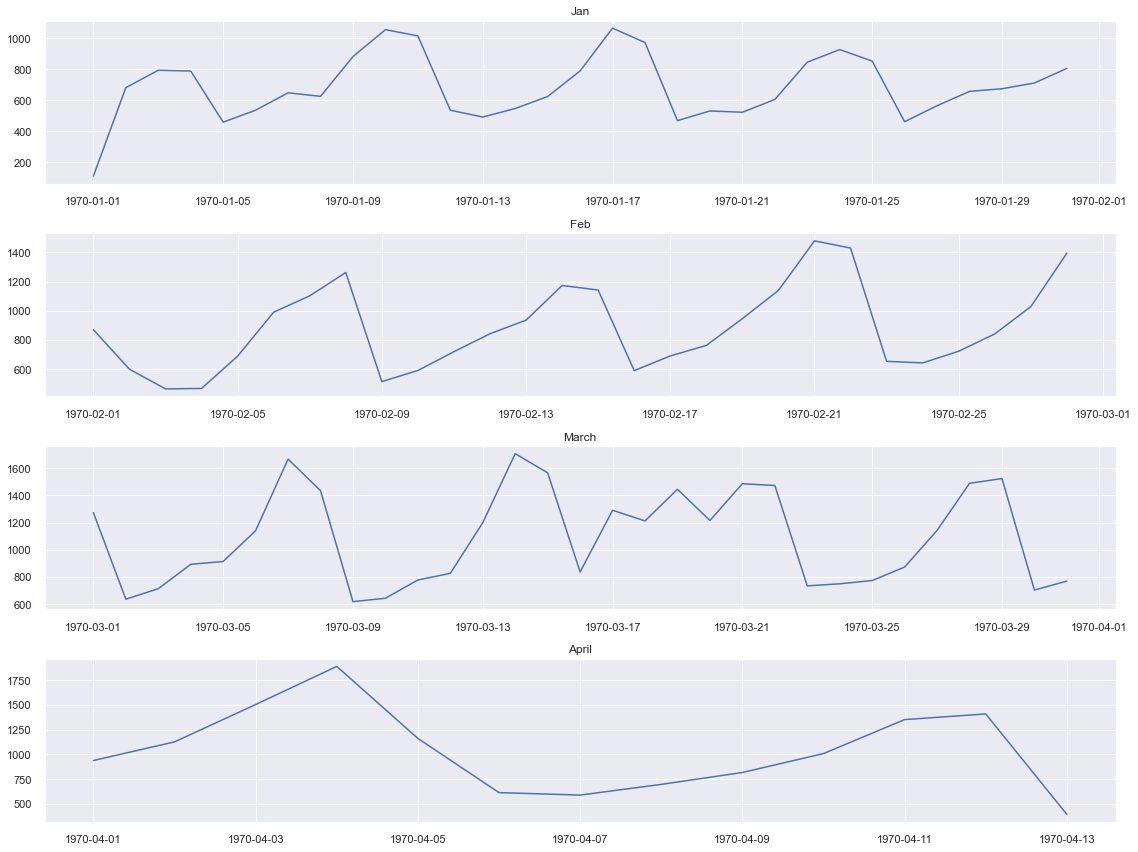

In [222]:
MONTH = ['Jan', 'Feb', 'March', 'April']

# Figure for plot
fig, ax = plt.subplots(nrows=4, figsize=(16, 12))

# For loop for day
# Set 'month' as index
for i2 in range(len(months)):
    ax[i2].plot(months[i2])
    ax[i2].set_title(MONTH[i2])
plt.tight_layout()

**February and May have the most peaks (at least 4 peaks). April has the least, with 2 peaks. Although April has the least peaks, it still has the more logins, with logins increasing montly from Jan-April.**

#